In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if not filename.endswith('tif'):
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv


KeyboardInterrupt: 

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import pickle, gzip
base_dir = '/kaggle/input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image
from sklearn.model_selection import train_test_split
from plotly.graph_objects import Figure, Pie
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
from tensorflow.distribute import MirroredStrategy
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [3]:
test = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv",dtype=str)
data = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv",dtype=str)

train_dir         = "/kaggle/input/histopathologic-cancer-detection/train/"
train_files       = os.listdir(train_dir)

test_dir          = "/kaggle/input/histopathologic-cancer-detection/test/"
test_files        = os.listdir(test_dir)

In [4]:
print("Train Size: {}".format(len(os.listdir("/kaggle/input/histopathologic-cancer-detection/train/"))))
print("Test Size: {}".format(len(os.listdir('/kaggle/input/histopathologic-cancer-detection/test/'))))

Train Size: 220025
Test Size: 57458


(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


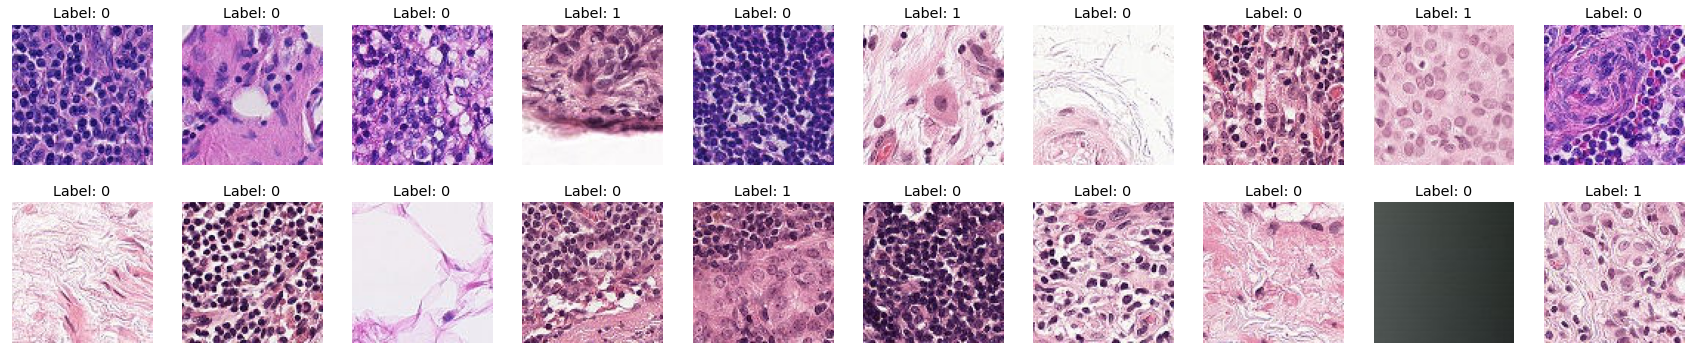

In [5]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    print(im.size)
    plt.imshow(im)
    lab = data.loc[data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)



In [6]:
data["id"] = data["id"].apply(lambda x: x + ".tif")
test["id"] = test["id"].apply(lambda x: x + ".tif")

data = data[data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif']
data = data[data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif']
print(data.head())

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


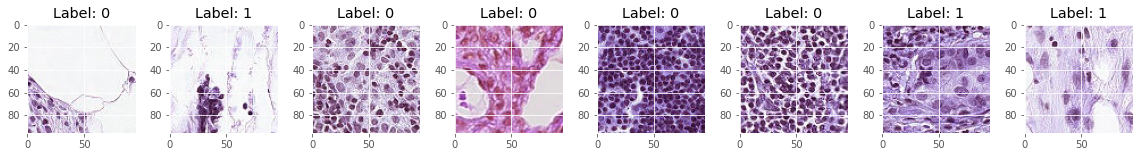

In [7]:
samples = 8
    
fig, axes = plt.subplots(1, len(data[:samples]), figsize = (20, 2))
for idx, ax in enumerate(axes):
    ax.imshow(cv2.imread(train_dir + data.id[idx]))
    ax.set_title("Label: " + str(data.label[idx]))

In [8]:
labels = ["No Cancer Detected", "Cancer Detected"]
values = data["label"].value_counts()

graph = Figure(data=[Pie(labels=labels, values=values, hole=0.5, marker_colors=["rgb(0, 203, 0)", "rgb(203, 0, 0)"])])
graph.show()

In [10]:
X = data["id"]
Y = data["label"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify = Y)
trainer, tester = train_test_split(data, test_size=0.20, random_state=42, stratify = Y)


In [11]:
datagen = ImageDataGenerator(rescale=1.0/255, validation_split = 0.25)
testgen = ImageDataGenerator(rescale=1.0/255)


train_gen = datagen.flow_from_dataframe(dataframe=trainer, directory = train_dir, x_col= "id", y_col= "label", class_mode= "binary", target_size= (96, 96), batch_size= 100, subset= "training", seed= 42)

valid_gen = datagen.flow_from_dataframe(dataframe=trainer, directory = train_dir,x_col="id", y_col="label", class_mode="binary" , target_size=(96,96), batch_size=100, subset = "validation", seed = 42)

test_gen = testgen.flow_from_dataframe(dataframe=tester, directory = train_dir,x_col="id", y_col="label", seed = 42, class_mode="binary", target_size=(96,96), batch_size=1, shuffle = False)

Found 132014 validated image filenames belonging to 2 classes.
Found 44004 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
labels = ["train", "valid", "test"] 
values =[train_gen.n , valid_gen.n , test_gen.n ]
graph = Figure(data=[Pie(labels=labels, values=values, hole=0.5, marker_colors=["rgb(0, 203, 0)","rgb(0, 0, 203)" , "rgb(203, 0, 0)"])])
graph.show()

In [ ]:
strat = MirroredStrategy()
with strat.scope():
    this_model = Sequential(
        [
            Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu', input_shape = (96, 96, 3), name = 'Conv2D_1'),
            Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_2'),
            Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_3'),
            Dropout(0.3, name = 'Dropout_1'),
            MaxPooling2D(pool_size = 3, name = 'MaxPooling2D_1'),
        
            Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_4'),
            Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_5'),
            Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_6'),
            Dropout(0.3, name = 'Dropout_2'),
            MaxPooling2D(pool_size = 3, name = 'MaxPooling2D_2'),
        
            Conv2D(filters=128, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_7'),
            
            Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_10'),
            Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu', name = 'Conv2D_11'),
            Flatten(name = 'Flatten_1'),
            Dense(512, activation="relu", name = 'Dense_1'),
            Dense(1, activation = "sigmoid", name = 'Dense_2')
        ]
)
this_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

this_model.summary()

In [ ]:
keras.utils.plot_model(this_model, show_shapes=True)

In [ ]:
batch_size = 100
num_samples = len(data)


es = EarlyStopping(monitor = "val_loss", patience = 3)
cp = ModelCheckpoint(filepath = "best_weights.hdf5", verbose=1, save_best_only=True)
cb = [cp,es]
eps = train_gen.n // batch_size
valid_steps = valid_gen.n // batch_size

prev_model = this_model.fit_generator(train_gen, epochs = 5,steps_per_epoch=eps, validation_data=valid_gen, validation_steps=valid_steps,callbacks = cb)

In [ ]:
# plt.clf()
# plt.plot(prev_model.history['loss'], 'b')
# plt.plot(prev_model.history['val_loss'], 'r')
# plt.grid(True)
# plt.gca().legend(['train','dev'], loc='upper right',fontsize=8)

plt.plot(prev_model.history['loss'])
plt.plot(prev_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()


In [ ]:
plt.plot(prev_model.history['accuracy'])
plt.plot(prev_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [107]:
strat = MirroredStrategy()
with strat.scope():
    cnn = keras.Sequential()
    cnn.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape= (96, 96, 3)))       
    cnn.add(Conv2D(filters=32, kernel_size=(3,3), padding='same' ))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))        
    cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding='same' ))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))   
    cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding='same' ))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))        
    cnn.add(Conv2D(filters=256, kernel_size=(3,3), padding='same' ))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.5))

    
    cnn.add(Flatten())

    cnn.add(Dense(256, activation="relu"))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(512, activation="relu"))
    cnn.add(Dense(1, activation = "sigmoid"))


cnn.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 48, 48, 64)       

In [ ]:
keras.utils.plot_model(cnn, show_shapes=True)

In [ ]:
batch_size = 100
num_samples = len(data)


es = EarlyStopping(monitor = "val_loss", patience = 3)
cp = ModelCheckpoint(filepath = "best_weights.hdf5", verbose=1, save_best_only=True)
cb = [cp,es]
eps = train_gen.n // batch_size
valid_steps = valid_gen.n // batch_size

prev_model = cnn.fit(train_gen, epochs = 5,steps_per_epoch=eps, validation_data=valid_gen, validation_steps=valid_steps,callbacks = cb)

Epoch 1/5
 374/1320 [=======>......................] - ETA: 12:13 - loss: 0.6130 - accuracy: 0.6956

In [ ]:
plt.plot(prev_model.history['loss'])
plt.plot(prev_model.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
plt.plot(prev_model.history['accuracy'])
plt.plot(prev_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [22]:
strat = MirroredStrategy()
with strat.scope():
    xin =keras.Input(shape=(96, 96, 3), name ="img")
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1),activation='relu', padding='same')(xin)  
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),activation='relu', padding='same')(x)

    a = keras.layers.Conv2D(1, kernel_size=(3, 3), strides=(1, 1),activation='sigmoid', padding='same')(x)
    x = keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1),activation='relu', padding='same')(x)

    x = keras.layers.Multiply()([x, a])

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(1)(x)  
    xout = keras.layers.Softmax()(x)

    model = keras.Model(inputs=xin, outputs=xout)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 96, 96, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 96, 96, 32)   4640        conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 96, 96, 64)   18496       conv2d_26[0][0]                  
______________________________________________________________________________________________

In [23]:
batch_size = 100
num_samples = len(data)


es = EarlyStopping(monitor = "val_loss", patience = 3)
cp = ModelCheckpoint(filepath = "best_weights.hdf5", verbose=1, save_best_only=True)
cb = [cp,es]
eps = train_gen.n // batch_size
valid_steps = valid_gen.n // batch_size

log= model.fit(train_gen, epochs = 15,steps_per_epoch=eps, validation_data=valid_gen, validation_steps=valid_steps,callbacks = cb)

Epoch 1/5
1320/1320 [==============================] - 497s 373ms/step - loss: 9.0720 - accuracy: 0.4051 - val_loss: 9.1087 - val_accuracy: 0.4027

Epoch 00001: val_loss improved from inf to 9.10865, saving model to best_weights.hdf5
Epoch 2/5
1320/1320 [==============================] - 386s 292ms/step - loss: 9.0631 - accuracy: 0.4057 - val_loss: 9.1080 - val_accuracy: 0.4027

Epoch 00002: val_loss improved from 9.10865 to 9.10796, saving model to best_weights.hdf5
Epoch 3/5
1320/1320 [==============================] - 393s 298ms/step - loss: 9.0542 - accuracy: 0.4063 - val_loss: 9.1080 - val_accuracy: 0.4027

Epoch 00003: val_loss did not improve from 9.10796
Epoch 4/5
1320/1320 [==============================] - 396s 300ms/step - loss: 9.0287 - accuracy: 0.4079 - val_loss: 9.1083 - val_accuracy: 0.4027

Epoch 00004: val_loss did not improve from 9.10796
Epoch 5/5
1320/1320 [==============================] - 400s 303ms/step - loss: 9.0674 - accuracy: 0.4054 - val_loss: 9.1087 - val_

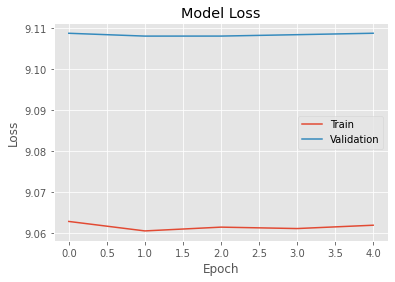

In [24]:
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()


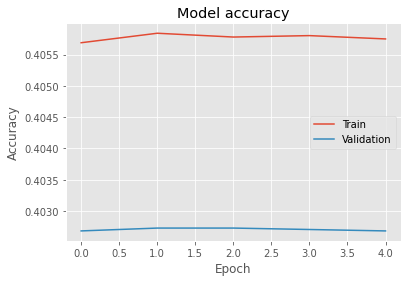

In [25]:
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [28]:
model.load_weights('best_weights.hdf5')
test_gen.reset()

model_att = keras.Model(inputs=xin, outputs=[xout, a])
y_pred_test, a_test = model_att.predict(test_gen, steps=len(test_gen.classes)-1, verbose=1)

#err = np.sum( y_pred_test.argmax(1) != train_gen )
#print('error rate test: %f %%' % (err / len(train_gen) * 100))


44004/44004 [==============================] - 383s 9ms/step


In [105]:
def view():
    k = 2
    for i in range(1):
        for j in range(1):
            plt.subplot(2, 4, 2*k+1)
            plt.imshow(cv2.imread(train_dir + data.id[k]), interpolation='none', cmap='gray')
            plt.title(r'$x_{%d}$' % k)
            plt.gca().axis('off')

            plt.subplot(2, 4, 2*k+2)
            plt.imshow( a_test[k], interpolation='none',cmap='gray')
            plt.title(r'$y_{%d}$' % k)
            plt.gca().axis('off')
            k += 1
    plt.show()
    

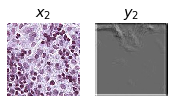

In [106]:
view()       
    